In [74]:
%%html
<style>
body {
    font-family: "Comic Sans MS", cursive, sans-serif;
}
</style>

# Word-cloud from Yelp reviews on restaurants from a given city
## [Dr. Tirthajyoti Sarkar](https://www.linkedin.com/in/tirthajyoti-sarkar-2127aa7/), Sunnyvale, CA, 2018

This notebook shows how to,
* crawl Yelp website for restaurant reviews city by city, 
* gather top reviews, and
* build word cloud from those user reviews

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import requests
import os

### Function to build a URL string from the name of a place (city)

In [2]:
def build_url_place(place=None):
    
    if place==None:
        place = input("Please enter the name of the place (city, State) you want to search restaurants in (e.g. \"Fremont, CA\"): ")
    
    if ',' in place:
        lst = [x.strip() for x in place.split(',')]
        if len(lst[0].split())>1:
            lst[0] ='+'.join(lst[0].split())

        baseurl = 'https://www.yelp.com/search?find_desc=Restaurants&find_loc='
        url = baseurl +lst[0]+',+'+lst[1]
    else:
        if len(place.split())>1:
            place ='+'.join(place.split())

        baseurl = 'https://www.yelp.com/search?find_desc=Restaurants&find_loc='
        url = baseurl +place
    
    return (url,place)

In [3]:
build_url_place('Chicago, IL')

('https://www.yelp.com/search?find_desc=Restaurants&find_loc=Chicago,+IL',
 'Chicago, IL')

### Function to build a URL string from an input of zip code 

In [4]:
def build_url_zip(zipcode=None):
    
    if zipcode==None:
        zipcode = input("Please enter the 5 digit zipcode (US) you want to search restaurants around: ")
    
    baseurl = 'https://www.yelp.com/search?find_desc=Restaurants&find_loc='
    url = baseurl +str(zipcode)
    
    return (url,zipcode)

In [5]:
build_url_zip('95129')

('https://www.yelp.com/search?find_desc=Restaurants&find_loc=95129', '95129')

### Function to place URL request and passing the data to `BeautifulSoup`

In [6]:
def read_soup_HTML(url):
    
    import urllib.request, urllib.parse, urllib.error
    from bs4 import BeautifulSoup
    import ssl

    # Ignore SSL certificate errors
    ctx = ssl.create_default_context()
    ctx.check_hostname = False
    ctx.verify_mode = ssl.CERT_NONE

    # Read the HTML from the URL and pass on to BeautifulSoup
    #print("Opening the page", url)
    uh= urllib.request.urlopen(url, context=ctx)
    html =uh.read()
    soup = BeautifulSoup(html, 'html.parser')
    return soup

### Testing with 'Chicago, IL'

In [7]:
url = build_url_place('Chicago, IL')[0]

In [8]:
s = read_soup_HTML(url)

### Function to build list of restaurant names

In [9]:
def build_restaurant_names (soup):
    restaurant_names = []
    for span in soup.find_all('span'):
        if 'class' in span.attrs:
            if span.attrs['class']==['indexed-biz-name']:
                restaurant_names.append(span.contents[1].get_text())
    
    return restaurant_names

In [10]:
build_restaurant_names(s)

['Girl & the Goat',
 'The Purple Pig',
 'Au Cheval',
 'The Dearborn',
 'Little Bad Wolf',
 'Quartino Ristorante',
 'Sapori Trattoria',
 'Penumbra',
 'Aba',
 'Crisp',
 'Angry Pig Tavern',
 'Serai',
 'Three Dots and a Dash',
 'Little Goat Diner',
 'Summer House Santa Monica',
 'TWO Restaurant',
 'Irazú Costa Rican Restaurant',
 'Giant',
 'Portillo’s Hot Dogs',
 'Green Street Local',
 'Mable’s Table',
 'Volare Ristorante Italiano',
 'Bavette’s Bar & Boeuf',
 'Smoque BBQ',
 'Bienmesabe',
 'Qing Xiang Yuan Dumplings',
 'Mini Mott',
 'Avec',
 'Fat Rice',
 'Mother Cluckers Kitchen Chicago']

### Function to build list of links to the restaurants

In [11]:
def build_restaurant_links (soup):
    restaurant_links=[]
    for a in soup.find_all('a'):
        if 'data-analytics-label' in a.attrs:
            if a.attrs['data-analytics-label']=='biz-name':
                if "osq=Restaurants" in str(a.attrs['href']):
                    restaurant_links.append(a.attrs['href'])
    
    #_=restaurant_links.pop(0)
    
    for i in range(len(restaurant_links)):
        link='https://yelp.com'+restaurant_links[i]
        restaurant_links[i]=link
    
    return restaurant_links

In [12]:
build_restaurant_links(s)

['https://yelp.com/biz/girl-and-the-goat-chicago?osq=Restaurants',
 'https://yelp.com/biz/the-purple-pig-chicago?osq=Restaurants',
 'https://yelp.com/biz/au-cheval-chicago?osq=Restaurants',
 'https://yelp.com/biz/the-dearborn-chicago-2?osq=Restaurants',
 'https://yelp.com/biz/little-bad-wolf-chicago?osq=Restaurants',
 'https://yelp.com/biz/quartino-ristorante-chicago?osq=Restaurants',
 'https://yelp.com/biz/sapori-trattoria-chicago?osq=Restaurants',
 'https://yelp.com/biz/penumbra-chicago?osq=Restaurants',
 'https://yelp.com/biz/aba-chicago-2?osq=Restaurants',
 'https://yelp.com/biz/crisp-chicago?osq=Restaurants',
 'https://yelp.com/biz/angry-pig-tavern-chicago?osq=Restaurants',
 'https://yelp.com/biz/serai-chicago?osq=Restaurants',
 'https://yelp.com/biz/three-dots-and-a-dash-chicago?osq=Restaurants',
 'https://yelp.com/biz/little-goat-diner-chicago-4?osq=Restaurants',
 'https://yelp.com/biz/summer-house-santa-monica-chicago-4?osq=Restaurants',
 'https://yelp.com/biz/two-restaurant-ch

### Function to query restaurants for an input of place (city)

In [13]:
def query_restaurant_place(num_restaurant,place=None,verbosity=1):
    
    import urllib.request, urllib.parse, urllib.error
    from bs4 import BeautifulSoup
    import ssl
    import pandas as pd
    
    num_loop_restaurant = 1+int(num_restaurant/11)
    
    if place==None:
        url,_ = build_url_place()
    else:
        url,_ = build_url_place(place)
    #print(url)
    
    if num_loop_restaurant==1:
        soup=read_soup_HTML(url)
        restaurant_names = build_restaurant_names(soup)
        restaurant_links = build_restaurant_links(soup)
    else:
        soup=read_soup_HTML(url)
        restaurant_names = build_restaurant_names(soup)
        restaurant_links = build_restaurant_links(soup)
        #print(restaurant_links)
        for i in range(1,num_loop_restaurant):
            url = url+'&start='+str(i*10)
            soup=read_soup_HTML(url)
            restaurant_names.extend(build_restaurant_names(soup))
            restaurant_links.extend(build_restaurant_links(soup))
    
    df=pd.DataFrame(data={'Link':restaurant_links,'Name':restaurant_names})
    if verbosity==1:
        print("\n Top restaurants found\n"+"-"*100)
        for name in restaurant_names[:num_restaurant]:
            print(name,end=', ')
    
    return df.iloc[:num_restaurant]

In [14]:
df1=query_restaurant_place(10,'Chicago, IL')


 Top restaurants found
----------------------------------------------------------------------------------------------------
Girl & the Goat, The Purple Pig, Au Cheval, The Dearborn, Little Bad Wolf, Quartino Ristorante, Sapori Trattoria, Penumbra, Aba, Crisp, 

### Function to query restaurants for an input of zipcode

In [15]:
def query_restaurant_zip(num_restaurant,zipcode=None,verbosity=0):
    
    import urllib.request, urllib.parse, urllib.error
    from bs4 import BeautifulSoup
    import ssl
    import pandas as pd
    
    num_loop_restaurant = 1+int(num_restaurant/11)
    
    if zipcode==None:
        url,_ = build_url_zipcode()
    else:
        url,_ = build_url_zip(zipcode)
    
    if num_loop_restaurant==1:
        soup=read_soup_HTML(url)
        restaurant_names = build_restaurant_names(soup)
        restaurant_links = build_restaurant_links(soup)
    else:
        soup=read_soup_HTML(url)
        restaurant_names = build_restaurant_names(soup)
        restaurant_links = build_restaurant_links(soup)
        for i in range(1,num_loop_restaurant):
            url = url+'&start='+str(i*10)
            soup=read_soup_HTML(url)
            restaurant_names.extend(build_restaurant_names(soup))
            restaurant_links.extend(build_restaurant_links(soup))
    
    df=pd.DataFrame(data={'Link':restaurant_links,'Name':restaurant_names})
    
    if verbosity==1:
        print("\n Top restaurants found\n"+"-"*100)
        for name in restaurant_names[:num_restaurant]:
            print(name,end=', ')
    
    return df.iloc[:num_restaurant]

In [16]:
query_restaurant_zip(10,'94086')

,Link,Name
0,https://yelp.com/biz/dishdash-sunnyvale?osq=Re...,DishDash
1,https://yelp.com/biz/the-oxford-sunnyvale?osq=...,The Oxford
2,https://yelp.com/biz/tre-monti-los-altos?osq=R...,tre monti
3,https://yelp.com/biz/fashion-wok-sunnyvale?osq...,Fashion Wok
4,https://yelp.com/biz/ramen-seas-sunnyvale?osq=...,Ramen Seas
5,https://yelp.com/biz/bonchon-sunnyvale-sunnyva...,Bonchon - Sunnyvale
6,https://yelp.com/biz/vaso-azzurro-ristorante-m...,Vaso Azzurro Ristorante
7,https://yelp.com/biz/yayoi-cupertino?osq=Resta...,YAYOI
8,https://yelp.com/biz/nom-burger-sunnyvale?osq=...,Nom Burger
9,https://yelp.com/biz/vino-vino-sunnyvale-3?osq...,Vino Vino


### Function to gather user reviews given a data table of restuarant links

In [17]:
def gather_reviews(df,num_reviews,verbosity=0):
    
    reviews={}
    num_links=df.shape[0]
    num_loop_reviews = 1+int(num_reviews/21)
    
    if verbosity==1:
        print("\n")
    
    for i in range(num_links):
        if verbosity==1:
            print(f"Gathering top reviews on {df.iloc[i]['Name']} now...")
        
        if num_loop_reviews==1:
            review_text=[]
            url=df.iloc[i]['Link']
            soup=read_soup_HTML(url)
            for p in soup.find_all('p'):
                if 'itemprop' in p.attrs:
                    if p.attrs['itemprop']=='description':
                        text=p.get_text().strip()
                        review_text.append(text)
        else:
            review_text=[]
            url=df.iloc[i]['Link']
            soup=read_soup_HTML(url)
            for p in soup.find_all('p'):
                if 'itemprop' in p.attrs:
                    if p.attrs['itemprop']=='description':
                        text=p.get_text().strip()
                        review_text.append(text)
            for i in range(1,num_loop_reviews):
                url=df.iloc[i]['Link']+'?start='+str(20*i)
                soup=read_soup_HTML(url)
                for p in soup.find_all('p'):
                    if 'itemprop' in p.attrs:
                        if p.attrs['itemprop']=='description':
                            text=p.get_text().strip()
                            review_text.append(text)
        
        reviews[df.iloc[i]['Name']]=review_text[:num_reviews]
        if verbosity==1:
            print(f"Reviews for {df.iloc[i]['Name']} gathered.\n"+"-"*60)
    
    return reviews

### Function to gather reviews given a place (city) name

In [18]:
def get_reviews_place(num_restaurant=10,num_reviews=20,place=None,verbosity=0):
    
    if place==None:
        df_restaurants = query_restaurant_place(num_restaurant=num_restaurant,verbosity=verbosity)
    else:
        df_restaurants = query_restaurant_place(num_restaurant=num_restaurant,place=place,verbosity=verbosity)
    
    reviews = gather_reviews(df_restaurants,num_reviews=num_reviews,verbosity=verbosity)
    
    return reviews

### Function to gather reviews given a zipcode

In [19]:
def get_reviews_zip(num_restaurant=10,num_reviews=20,zipcode=None,verbosity=0):
    
    if zipcode==None:
        df_restaurants = query_restaurant_zip(num_restaurant=num_restaurant)
    else:
        df_restaurants = query_restaurant_zip(num_restaurant=num_restaurant,zipcode=zipcode)
    
    reviews = gather_reviews(df_restaurants,num_reviews=num_reviews,verbosity=verbosity)
    
    return reviews

### Test cases

In [22]:
rev = get_reviews_place(num_restaurant=5,num_reviews=15,place='Chicago, IL',verbosity=1)


 Top restaurants found
----------------------------------------------------------------------------------------------------
Girl & the Goat, The Purple Pig, Au Cheval, The Dearborn, Aba, 

Gathering top reviews on Girl & the Goat now...
Reviews for Girl & the Goat gathered.
------------------------------------------------------------
Gathering top reviews on The Purple Pig now...
Reviews for The Purple Pig gathered.
------------------------------------------------------------
Gathering top reviews on Au Cheval now...
Reviews for Au Cheval gathered.
------------------------------------------------------------
Gathering top reviews on The Dearborn now...
Reviews for The Dearborn gathered.
------------------------------------------------------------
Gathering top reviews on Aba now...
Reviews for Aba gathered.
------------------------------------------------------------


## Word Cloud generation

### Function to generate word cloud from text

In [23]:
def wordcloud_from_text(text):
    from PIL import Image
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    
    stopwords = set(STOPWORDS)
    more_stopwords=['food','good','bad','came','place','restaurant','really','much','less','more']
    for word in more_stopwords:
        stopwords.add(word)

    wc = WordCloud(background_color="white", max_words=50, stopwords=stopwords,max_font_size=40)
    _=wc.generate(text)
    
    plt.figure(figsize=(10,7))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### Function to generate word cloud from review data

In [24]:
def wordcloud_from_reviews(review_dict):
    from PIL import Image
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    
    stopwords = set(STOPWORDS)
    more_stopwords=['food','good','bad','came','place','restaurant','really','much','less','more']
    for word in more_stopwords:
        stopwords.add(word)

    wc = WordCloud(background_color="white", max_words=50, stopwords=stopwords,max_font_size=40)
    
    for restaurant in review_dict:
        text = '\n'.join(review_dict[restaurant])
        _= wc.generate(text)
        
        plt.figure(figsize=(10,7))
        plt.title(f"Wordcloud for {restaurant}\n",fontsize=20)
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.show()

### Function to plot the word cloud

In [25]:
def plot_wc(wc,place=None, restaurant=None):
    plt.figure(figsize=(12,8))
    
    if place!=None:
        plt.title("{}\n".format(place),fontsize=20)
        
    if restaurant!=None:
        plt.title("{}\n".format(restaurant),fontsize=20)
    
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### Function to generate and show word cloud given a city name

In [26]:
def wordcloud_city(place=None,num_restaurant=10,num_reviews=20,stopword_list=None,
                   disable_default_stopwords=False,verbosity=0):
    
    from PIL import Image
    from wordcloud import WordCloud, STOPWORDS
    import matplotlib.pyplot as plt
    
    if place==None:
        review_dict=get_reviews_place(num_restaurant=num_restaurant,num_reviews=num_reviews,verbosity=verbosity)
    else:
        review_dict=get_reviews_place(num_restaurant=num_restaurant,num_reviews=num_reviews,
                                      place=place,verbosity=verbosity)
    
    text=""
    
    for restaurant in review_dict:
        text_restaurant = '\n'.join(review_dict[restaurant])
        text+=text_restaurant
    
    # Add custom stopwords to the default list
    stopwords = set(STOPWORDS)
    more_stopwords=['food','good','bad','best','amazing','go','went','came','come','back','place','restaurant',
                    'really','much','less','more','order','ordered','great','time','wait','table','everything',
                   'take','definitely','sure','recommend','recommended','delicious','taste','tasty',
                   'menu','service','meal','experience','got','night','one','will','made','make',
                    'bit','dish','dishes','well','try','always','never','little','big','small', 'nice','excellent']
    if not disable_default_stopwords:
        for word in more_stopwords:
            stopwords.add(word)
    if stopword_list!=None:
        for word in stopword_list:
            stopwords.add(word)

    wc = WordCloud(background_color="white", max_words=50, stopwords=stopwords,max_font_size=40,scale=3)
    _= wc.generate(text)
    
    plot_wc(wc,place=place)
    
    return wc

### Testing world cloud with the gathered review texts

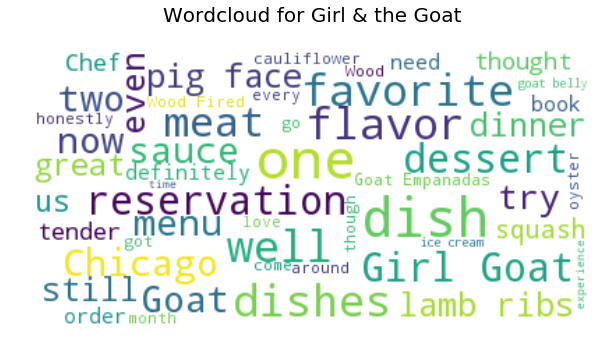

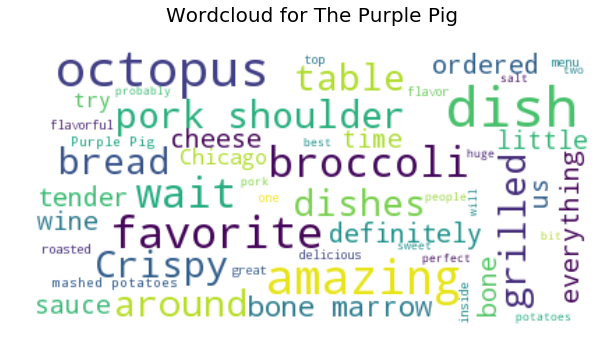

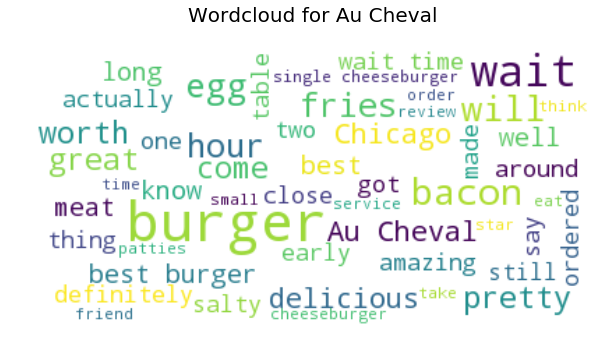

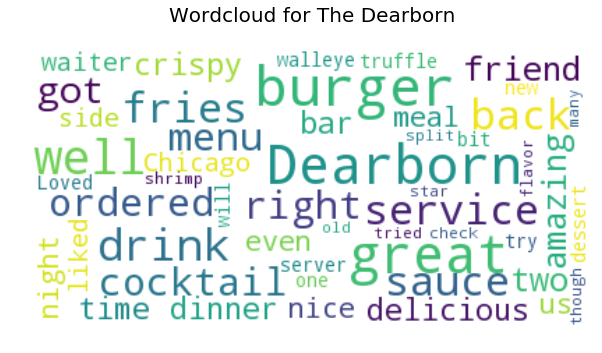

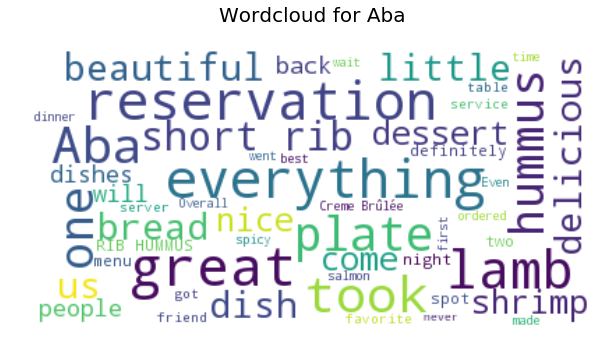

In [27]:
wordcloud_from_reviews(rev)

### Testing world cloud directly with a city name

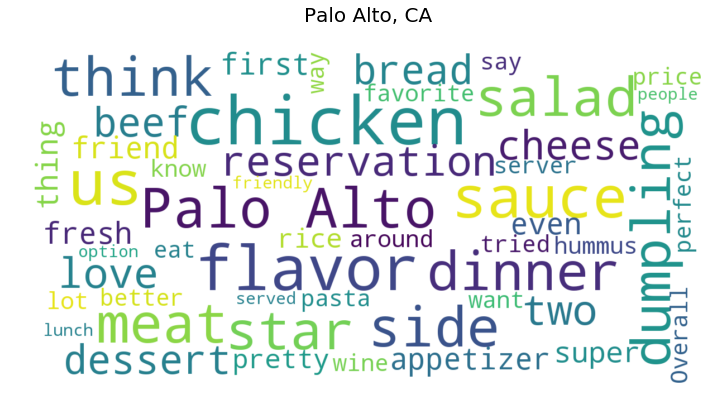

In [28]:
wordcloud_city(place='Palo Alto, CA',num_restaurant=20)